# Geographic patterns of population differentiation and gene flow

## Introduction

This notebook recreates [Supplementary Table 6 and 7 from the Pf7 paper](https://figshare.com/ndownloader/files/38478530 ) - tables which depict the genetic distance ($F_{ST}$) and geographic distance between subpopulations. It contains two panels, A) which compares African subpopulations and B) which compares Asian Southeast West and Asian Southeast East populations with all other subpopulations.

**This notebook should take approximately 2 minutes to run.**

## Setup

Install and import the malariagen Python package:

In [1]:
!pip install -q --no-warn-conflicts malariagen_data
import malariagen_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.5/148.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.5/302.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 

Import required python libraries that are installed at colab by default.

In [2]:
# required for data formatting
import numpy as np
import pandas as pd
from typing import Dict, Any, List
import collections
# required to calculate great circle distance
from math import radians, cos, sin, asin, sqrt
# required for plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import itertools
import matplotlib.ticker as ticker
# required for saving the figure
from google.colab import drive

## Access Pf7 Data

We use the malariagen data package to load the release data.

In [3]:
release_data = malariagen_data.Pf7()
df_samples = release_data.sample_metadata()

## Figure Preparation: Defining Geographic Regions

In Pf7, countries are grouped into ten major sub-populations based on their geographic and genetic characteristics.

`df_samples` dataframe has a `Population` column that contains abbreviated names for each sub-population to which we can assign a specific colour to be used in the figure.

In [4]:
georegions = collections.OrderedDict([
    ('SA',dict(n='South America', c='#4daf4a')),
    ('all_africa',dict(n='Africa', c='#faedcb')),
    ('AF-W',dict(n='West Africa', c='#e31a1c')),
    ('AF-C',dict(n='Central Africa', c='#fd8d3c')),
    ('AF-NE',dict(n='Northeast Africa', c='#bb8129')),
    ('AF-E',dict(n='East Africa', c='#fecc5c')),

    ('AS-S-FE',dict(n='Asia - South - West', c='#dfc0eb')),
    ('AS-S-E',dict(n='Asia - South - East', c='#984ea3')),

    ('AS-SE-W',dict(n='Asia - Southeast - West', c='#9ecae1')),
    ('AS-SE-E',dict(n='Asia - Southeast - East', c='#3182bd')),

    ('OC-NG',dict(n='Oceania - New Guinea', c='#f781bf'))])

We would like to plot African and Asian sub-populations separately to do a region-wise comparison.

We can do this by mapping the continent name codes using subpopulation name codes existing in the `Population` column of `df_samples` dataset.

In [5]:
# Match continent name codes with subpopulations: AM (America), AF (Africa), AS (Asia), OC (Oceania)
continent_codes = {'SA': 'AM', 'AF-W': 'AF', 'AF-C': 'AF', 'AF-NE': 'AF', 'AF-E': 'AF',
                  'AS-S-FE': 'AS', 'AS-S-E': 'AS', 'AS-SE-W': 'AS', 'AS-SE-E': 'AS', 'OC-NG': 'OC'}
# Map the continent name codes using population name codes
df_samples['ContinentCode'] = df_samples['Population'].map(continent_codes)

Now that we added continents, we can find out how many countries are assigned in each continent.

In [6]:
# Count the country in each continent
df_samples['ContinentCode'].value_counts(dropna=False)

AF     11290
AS      8848
OC       384
AM       182
NaN      160
Name: ContinentCode, dtype: int64

## Calculating Geographic Distance

We can calculate the geographic distance between between two points (on our case, populations) on the Earth's surface using their latitude and longitude coordinates.

We will create a custom function for this task.

In [7]:
# Create a function
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


Now, it is time to calculate the geographic distances between populations. To step-by-step do that:

*   we will create pair population pairs
*   calculates distances between them
*   stores the results in a structured DataFrame

Only QC-pass samples will be included in the calculation.

In [8]:
# Filter samples based on quality control criteria
filtered_samples = df_samples[df_samples['QC pass']]

# Define aggregation parameters for latitude and longitude
aggregation = {
        'Country latitude': 'mean',
        'Country longitude': 'mean'
    }
# Group samples by the 'Population' column and perform aggregation
gc = filtered_samples.groupby('Population').agg(aggregation)

# Create a list of population pairs, excluding self-pairs
pop_pairs_list = [[i, j] for i in gc.index for j in gc.index if i != j]

# Create a MultiIndex to represent the pairs
geo_index = pd.MultiIndex.from_tuples(pop_pairs_list, names=['first', 'second'])

# Initialize a DataFrame to store distances
geo_distances = pd.DataFrame(columns=['distance'], index=geo_index)

# Calculate distances and populate the 'distance' column in geo_distances
for f in geo_distances.iterrows():
    geo_distances.loc[f[0]].distance = haversine(
        lat1=gc['Country latitude'][f[0][0]],
        lon1=gc['Country longitude'][f[0][0]],
        lat2=gc['Country latitude'][f[0][1]],
        lon2=gc['Country longitude'][f[0][1]]
    )
# Print the results
geo_distances

distance
first second               
AF-C  AF-E      1408.618195
      AF-NE     1717.731717
      AF-W      3354.887193
      AS-S-E    6700.558535
      AS-S-FE   7724.625897
...                     ...
SA    AS-S-E   15945.593911
      AS-S-FE  16574.510674
      AS-SE-E  17994.185511
      AS-SE-W  17558.854817
      OC-NG     16823.02993

[90 rows x 1 columns]

## Access to mean $F_{ST}$ values between all major sub-subpopulations


$F_{ST}$, also known as the Fixation Index, is a measure of how genetic differences within a population compare to genetic differences between populations. $F_{ST}$ = 0 means there is no difference between populations, conversely, $F_{ST}$ = 1 indicates there is complete genetic differentiation between populations. For a deeper understanding on $F_{ST}$ statistics, consider referring to the following resources:

*   **[Estimation of Levels of Gene Flow from DNA Sequence Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1205159/)** by *Hudson et al.*
*   **[Estimating and interpreting FST: The impact of rare variants](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759727/)** by *Bhatia et al.*
*   **[A short video about $F_{ST}$ statistics](https://www.youtube.com/watch?v=I8RCOI7n4XI)** by *Sarah Tishkoff* from U. Pennsylvania  


In this notebook, we will leverage pre-calculated mean $F_{ST}$ values between all major sub-subpopulations, which were previously computed for Pf7 using [Hudson’s method as implemented in scikit-allel v1.2.0](https://scikit-allel.readthedocs.io/en/stable/stats/fst.html)



In [10]:
# Our website is undergoing some maintenance, please use this temporary URL
# Try this URL
fst = pd.read_csv('https://www.malariagen.net/wp-content/uploads/2024/01/fst_populations_all_snps_pf7.txt', sep='\t', index_col=0)

# But if it does not work, try this URL (uncomment the command)
#fst = pd.read_csv('https://www.malariagen.net/sites/default/files/fst_populations_all_snps_pf7.txt', sep='\t', index_col=0)

# Rename subpopulation names in accordance with Pf7
fst.rename(columns={"AS-SA-W": "AS-S-FE", "AS-SA-E": "AS-S-E", 'AS-SEA-W': 'AS-SE-W', 'AS-SEA-E' : 'AS-SE-E'}, inplace=True)

# Rename the index values with the new subpopulation names
fst = fst.set_index(fst.columns)
fst

,SA,AF-W,AF-C,AF-NE,AF-E,AS-S-FE,AS-S-E,AS-SE-W,AS-SE-E,OC-NG
SA,0.0,0.210957,0.216355,0.221376,0.215139,0.257292,0.273814,0.348240,0.376699,0.345133
AF-W,0.0,0.000000,0.015034,0.030750,0.021481,0.089009,0.111180,0.200027,0.229990,0.201879
AF-C,0.0,0.000000,0.000000,0.024246,0.009104,0.084730,0.106478,0.193681,0.224552,0.196541
AF-NE,0.0,0.000000,0.000000,0.000000,0.020444,0.087930,0.107703,0.187708,0.219425,0.192452
AF-E,0.0,0.000000,0.000000,0.000000,0.000000,0.081217,0.101255,0.185666,0.215896,0.189025
AS-S-FE,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.031117,0.115080,0.151120,0.145261
AS-S-E,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064807,0.102968,0.121421
AS-SE-W,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070569,0.134227
AS-SE-E,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159498
OC-NG,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


This is an upper triangle matrix, which contains many 0 values that we can replace with the true values.

At the end, we will have a symmetric matrix, and only self-pairs will be 0.


In [11]:
# We can pretty easily make into a symmetric matrix using the handy numpy function triu along with a transpose
arr = np.triu(fst) + np.triu(fst,1).T
# Get the population names in a list for symmetric dataframe
pop_names = list(fst.columns.values)
# Create the symmetric matrix
fst_symmetric = pd.DataFrame(arr.reshape(10, 10), columns=pop_names, index=pop_names).replace(0, np.nan)
fst_symmetric

,SA,AF-W,AF-C,AF-NE,AF-E,AS-S-FE,AS-S-E,AS-SE-W,AS-SE-E,OC-NG
SA,NaN,0.210957,0.216355,0.221376,0.215139,0.257292,0.273814,0.348240,0.376699,0.345133
AF-W,0.210957,NaN,0.015034,0.030750,0.021481,0.089009,0.111180,0.200027,0.229990,0.201879
AF-C,0.216355,0.015034,NaN,0.024246,0.009104,0.084730,0.106478,0.193681,0.224552,0.196541
AF-NE,0.221376,0.030750,0.024246,NaN,0.020444,0.087930,0.107703,0.187708,0.219425,0.192452
AF-E,0.215139,0.021481,0.009104,0.020444,NaN,0.081217,0.101255,0.185666,0.215896,0.189025
AS-S-FE,0.257292,0.089009,0.084730,0.087930,0.081217,NaN,0.031117,0.115080,0.151120,0.145261
AS-S-E,0.273814,0.111180,0.106478,0.107703,0.101255,0.031117,NaN,0.064807,0.102968,0.121421
AS-SE-W,0.348240,0.200027,0.193681,0.187708,0.185666,0.115080,0.064807,NaN,0.070569,0.134227
AS-SE-E,0.376699,0.229990,0.224552,0.219425,0.215896,0.151120,0.102968,0.070569,NaN,0.159498
OC-NG,0.345133,0.201879,0.196541,0.192452,0.189025,0.145261,0.121421,0.134227,0.159498,NaN


Now, both geographic and genetic distance data are ready for plotting.

## Plotting the genetic-geographic distance between major sub-populations

We will start creating Subplot 1 which shows the geo-genetic distances between African subpopulations and Subplot 2 which shows Asian Southeast West and Asian Southeast East populations with all other subpopulations.

Briefly, after adjusting various figure parameters, we will iterate through combinations of pairs of populations and retrieve their corresponding geographic distance and Fst values.

For visual clarity, we join pairs of markers in Subplot 2 with connecting lines.

Text(0.5, 0, 'Geographic distance (great-circle distance in km)')

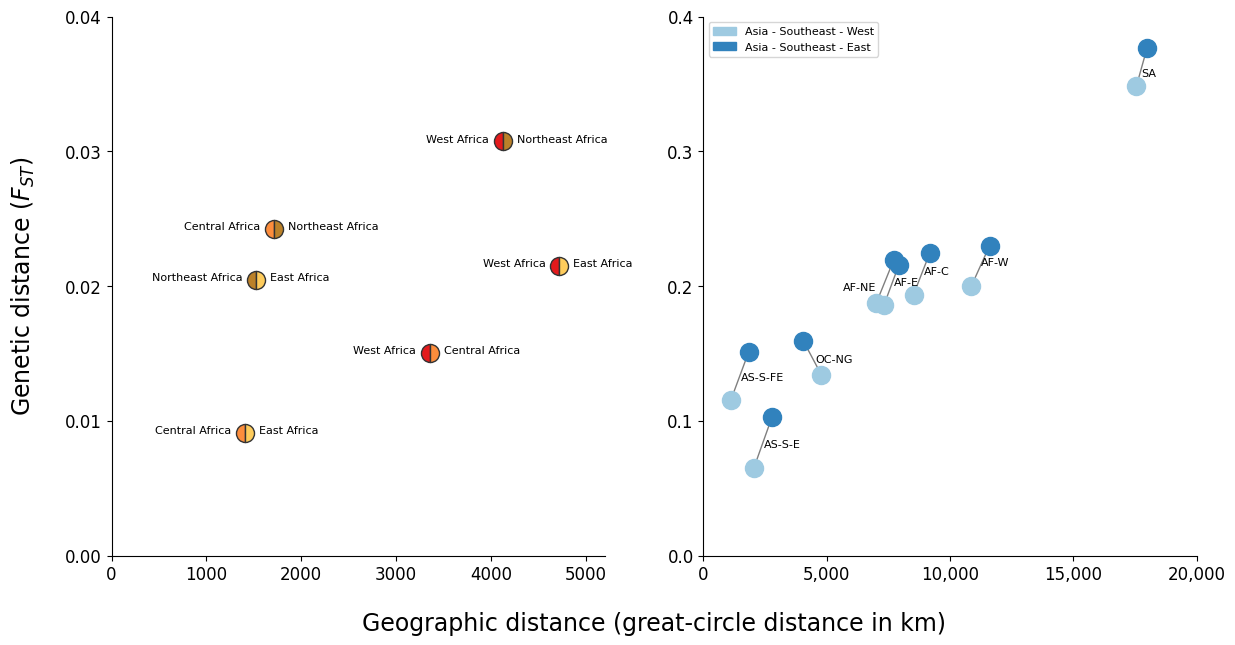

In [12]:
# Adjust font, label and tick sizes
rcParams = plt.rcParams
rcParams['font.size'] = 8
rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Create 2 subplots, one for Africa (ax) and one for Asia&others (ax1)
fig, (ax1,ax) = plt.subplots(1,2, figsize=(14, 7))

# Customize subplot appearance
# Remove the top and intersecting spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

### PLOT 1 - African populations

# Set axis limits and labels
ax.set_xlim([0,20001])
ax.set_ylim([0,0.4])
ax.set_xticks(np.arange(0,20001,5000))
ax.set_yticks(np.arange(0,0.41,0.1))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

af_pop_names = ['AF-W','AF-C','AF-NE','AF-E']

# Iterate through all combinations of population pairs
for pop in list(itertools.combinations(pop_names, r=2)):

    # Check if both populations are African populations
    if (pop[0] in af_pop_names) & (pop[1] in af_pop_names):
        # Save values for plotting
        fst_val = fst.loc[pop[0],pop[1]]
        geo_distance= geo_distances.loc[pop[0],pop[1]]


        marker_style = dict( c=georegions[pop[0]]['c'],linestyle=':', marker='o',
                    markersize=13, markerfacecoloralt=georegions[pop[1]]['c'], markeredgecolor='#333333')

        ax1.plot(geo_distance, fst_val,
                fillstyle='left', **marker_style)

        ax1.annotate(georegions[pop[0]]['n'],  (geo_distance-145, fst_val-0.00007),horizontalalignment='right')
        ax1.annotate(georegions[pop[1]]['n'],  (geo_distance+145, fst_val-0.00007),horizontalalignment='left')

### PLOT 2 - Asian and other populations

# Store fst and geo values to use after plotting
fst_values = []
geo_values = []

# Set axis limits and labels
ax1.set_xlim([0,5200])
ax1.set_ylim([0,0.04])
ax1.set_yticks(np.arange(0,0.041,0.01))
ax1.set_ylabel('Genetic distance ($F_{ST}$)', fontsize=17,labelpad=20)

# Iterate through all combinations for population
for pop in list(itertools.combinations(pop_names, r=2)):

    if ('AS-SE-E' in pop) ^ ('AS-SE-W' in pop):

        fst_val = fst.loc[pop[0],pop[1]]
        geo_distance= geo_distances.loc[pop[0],pop[1]]

        if 'AS-SE-E' in pop:
            fst_values.append(fst_val)
            geo_values.append(geo_distance[0])

            marker_style = dict(color=georegions['AS-SE-E']['c'], linestyle=':', marker='o',
                        markersize=13)

        elif 'AS-SE-W' in pop:
            fst_values.append(fst_val)
            geo_values.append(geo_distance[0])

            marker_style = dict(color=georegions['AS-SE-W']['c'], linestyle=':', marker='o',
                        markersize=13)

            secondary_pop = [pop[n] for n in range(len(pop)) if (pop[n] != 'AS-SE-W')]

            # Align labels to markers
            if secondary_pop == ['AF-NE']:
                ax.annotate(''.join(secondary_pop),  (geo_distance-10, fst_val+0.009),horizontalalignment='right')
            elif secondary_pop == ['OC-NG']:
                ax.annotate(''.join(secondary_pop),  (geo_distance+1300, fst_val+0.009),horizontalalignment='right')
            elif secondary_pop == ['SA']:
                ax.annotate(''.join(secondary_pop),  (geo_distance+800, fst_val+0.007),horizontalalignment='right')

            else:
                ax.annotate(''.join(secondary_pop), (geo_distance+400, fst_val+0.015))

        ax.plot(geo_distance, fst_val, **marker_style)

# Create legend for population colors
pop1 = mpatches.Patch(color=georegions['AS-SE-W']['c'], label='Asia - Southeast - West')
pop2 = mpatches.Patch(color=georegions['AS-SE-E']['c'], label='Asia - Southeast - East')
ax.legend(handles=[pop1,pop2])

# Join pairs of markers with connecting lines
connect_markers = [n for n in range(len(fst_values)) if n % 2 == 0]
for n in connect_markers:
    ax.plot([geo_values[n],geo_values[n+1]],[fst_values[n],fst_values[n+1]],'-k',linewidth=1, alpha=.5,zorder=1)

# Add subplots to the figure
fig.add_subplot(111, frameon=False)
# Make the extra tick labels invisible
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# Set common x-axis label
plt.xlabel('Geographic distance (great-circle distance in km)', fontsize=17, labelpad=20)

**Figure Legend. Geographic patterns of population differentiation and gene flow.**
Each point represents one pairwise comparison between two regional parasite sub- populations. The x-axis reports the geographic separation between the two sub- populations, measured as great-circle distance between the centre of mass of each sub- population and without taking into account natural barriers. The y-axis reports the genetic differentiation between the two sub-populations, measured as average genome-wide FST. These two figures show that the sub-populations from northeast Africa and the eastern part of SE Asia are more genetically distinct from other sub-populations than might be expected due to their geographic separation. (A) Comparison of African sub-populations. Points are coloured based on the two sub-populations they represent. The distance from northeast Africa (AF-NE) to other African sub-populations is generally greater than that between the other African sub-populations. For example the central African sub-population (AF-C) is closer genetically to the west African sub-population (AF-W) than it is to the northeast African sub-population, despite being closer geographically to the latter. (B) Comparison of two SE Asian sub-populations against all other sub-populations. Compared to all other sub- populations, the sub-population from the eastern part of SE Asia (AS-SEA-E) generally has a greater genetic distance than that from the western part of SE Asia, and this difference in genetic distances is more than might be expected due to the extra geographic distance.

### Save the figure

We can output this to a location in Google Drive.

First we need to connect Google Drive by running the following:

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/GeneticGeographicDistance.pdf')
fig.savefig('/content/drive/My Drive/GeneticGeographicDistance.png', dpi=240) # increase the dpi for higher resolution